# 필수 실행


## 구글드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 필수 설치

In [2]:
!pip install category_encoders

## 필수 임포트

In [3]:
import os
import random
import numpy as np
import pandas as pd

# 인코더
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager as fm
import tqdm
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)

# seed값 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

## csv파일 불러오기


In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/daegu/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/daegu/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/daegu/sample_submission.csv')
extra_train_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/countrywide_accident.csv')
light_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구보안등정보.csv',encoding='cp949')
child_area_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구어린이보호구역정보.csv',encoding='cp949')
parking_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구주차장정보.csv',encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구CCTV정보.csv',encoding='cp949')

In [5]:
train_df['사망자수'].value_counts()

0    39309
1      292
2        8
Name: 사망자수, dtype: int64

## train/test data 합치기 및 컬럼정리


- 필요없다고 생각한 컬럼 정리

In [6]:
light_df = light_df.drop(columns=['보안등위치명','소재지도로명주소','위도','경도'])
child_area_df = child_area_df.drop(columns=['소재지도로명주소','위도','경도','데이터기준일자'])
parking_df = parking_df.drop(columns=['주차장관리번호','소재지도로명주소','위도','경도','데이터기준일자'])
cctv_df = cctv_df.drop(columns=['소재지도로명주소','위도','경도'])

In [7]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

- 보안등 정보

In [8]:
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

In [9]:
light_df = pd.get_dummies(light_df, columns=['설치형태'])

In [10]:
light_df['설치개수평균'] = light_df['설치개수']

light_ = light_df[['설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
                   '설치개수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
light__ = light_df[['설치개수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [11]:
light_.reset_index(inplace=True, drop=True)
light__.reset_index(inplace=True, drop=True)

- 어린이 보호구역

In [12]:
child_area_df['CCTV설치대수'].fillna(0, inplace=True)
child_area_df['CCTV설치한곳의수'] = 1
child_area_df['CCTV설치대수평균'] = child_area_df['CCTV설치대수']

In [13]:
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

In [14]:
child_area_df = pd.get_dummies(child_area_df, columns=['시설종류','관할경찰서명','CCTV설치여부'])

In [15]:
child_area_ = child_area_df[['시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y','CCTV설치한곳의수','CCTV설치대수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
child_area__ = child_area_df[['CCTV설치대수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [16]:
child_area_.reset_index(inplace=True, drop=True)
child_area__.reset_index(inplace=True, drop=True)

- 주차장 정보

In [17]:
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df['주차구획수평균'] = parking_df['주차구획수']

parking_df = pd.get_dummies(parking_df, columns=['급지구분','결제방법','주차장구분','주차장유형'])


parking_df_ = parking_df[['급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외','주차구획수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
parking_df__ = parking_df[['주차구획수평균','주차기본요금','추가단위요금',
                           '1일주차권요금','월정기권요금','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

parking_df_.reset_index(inplace=True, drop=True)
parking_df__.reset_index(inplace=True, drop=True)

- cctv 정보

In [18]:
cctv_df['무인CCTV설치한곳의수'] = 1

In [19]:
cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소', '번지'])

In [20]:
cctv_df = pd.get_dummies(cctv_df, columns=['도로노선방향'])

In [21]:
cctv_ = cctv_df[['도로노선방향_1', '도로노선방향_2','도로노선방향_3',
                 '무인CCTV설치한곳의수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
cctv__ = cctv_df[['설치연도','제한속도','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [22]:
cctv_.reset_index(inplace=True, drop=True)
cctv__.reset_index(inplace=True, drop=True)

- '사고일시' 분리

In [23]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

- '시군구' 분리

In [24]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

- '도로형태'분리

In [25]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)

- 추가정보들 일단 모두 merge하기

In [26]:
print(f'{light_df.shape}/{child_area_df.shape}/{parking_df.shape}/{cctv_df.shape}')

(71913, 9)/(640, 24)/(871, 39)/(1065, 20)


In [27]:
parking_df.columns

Index(['주차장명', '주차구획수', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '특기사항', '도시',
       '구', '동', '주차구획수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드',
       '결제방법_무료', '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금',
       '결제방법_현금+신용카드', '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영',
       '주차장유형_노상', '주차장유형_노외'],
      dtype='object')

In [28]:
train_df = train_df.drop(columns=['사고유형 - 세부분류', '법규위반',
                                  '가해운전자 차종', '가해운전자 성별','가해운전자 연령', '가해운전자 상해정도',
                                  '피해운전자 차종','피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도',
                                  ])

In [29]:
train_df = pd.merge(train_df, light_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, light__, how='left', on=['도시', '구', '동'])

In [30]:
train_df = pd.merge(train_df, child_area_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area__, how='left', on=['도시', '구', '동'])

In [31]:
train_df = pd.merge(train_df, parking_df_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df__, how='left', on=['도시', '구', '동'])

In [32]:
train_df = pd.merge(train_df, cctv_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv__, how='left', on=['도시', '구', '동'])

# EDA

## 1. 데이터 이해

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 71 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  39609 non-null  object 
 1   요일                  39609 non-null  object 
 2   기상상태                39609 non-null  object 
 3   도로형태                39609 non-null  object 
 4   노면상태                39609 non-null  object 
 5   사고유형                39609 non-null  object 
 6   사망자수                39609 non-null  int64  
 7   중상자수                39609 non-null  int64  
 8   경상자수                39609 non-null  int64  
 9   부상자수                39609 non-null  int64  
 10  ECLO                39609 non-null  int64  
 11  연                   39609 non-null  int64  
 12  월                   39609 non-null  int64  
 13  일                   39609 non-null  int64  
 14  시간                  39609 non-null  int64  
 15  도시                  39609 non-null  object 
 16  구   

In [36]:
train_df.describe()

,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,설치형태_건축물,설치형태_전용주,설치형태_한전주,설치개수,설치개수평균,시설종류_어린이집,시설종류_유치원,시설종류_초등학교,시설종류_특수학교,시설종류_학원,관할경찰서명_강북경찰서,관할경찰서명_남부경찰서,관할경찰서명_달성경찰서,관할경찰서명_대구광역시 중부경찰서,관할경찰서명_대구동부경찰서,관할경찰서명_북부경찰서,관할경찰서명_서부경찰서,관할경찰서명_수성경찰서,CCTV설치여부_N,CCTV설치여부_Y,CCTV설치한곳의수,CCTV설치대수,CCTV설치대수평균,급지구분_1,급지구분_2,급지구분_3,결제방법_교통카드,결제방법_무료,결제방법_신용카드,"결제방법_신용카드, 교통카드",결제방법_카드,결제방법_현금,결제방법_현금+신용카드,"결제방법_현금, 신용카드","결제방법_현금,카드",주차장구분_공영,주차장구분_민영,주차장유형_노상,주차장유형_노외,주차구획수,주차구획수평균,주차기본요금,추가단위요금,1일주차권요금,월정기권요금,도로노선방향_1,도로노선방향_2,도로노선방향_3,무인CCTV설치한곳의수,설치연도,제한속도
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,30096.000000,30096.000000,30096.000000,30096.000000,30096.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.0,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.00000,33066.000000,33066.000000,24540.000000,23141.000000,22398.000000,38033.000000,38033.000000,38033.000000,38033.000000,38033.000000,38033.000000
mean,0.007776,0.262365,1.070085,0.126865,4.726704,2019.939332,6.678507,15.817087,13.934863,148.281067,8.084762,369.095827,881.939427,1.006913,3.263372,5.789831,4.001936,0.456168,0.042865,1.258226,2.435160,3.763490,0.179106,0.0,0.901336,2.093282,2.923571,3.593400,9.960770,13.554171,19.430109,1.813463,2.549961,4.501210,3.164217,0.009043,0.038166,0.020958,0.005141,0.061786,2.714752,0.000544,0.022319,0.083772,9.477893,0.737495,6.088762,4.126626,454.17202,52.584840,253.650388,421.779472,4910.845315,55673.601283,5.411800,4.442353,3.978913,13.833066,2017.872704,38.508138
std,0.090109,0.500845,0.992034,0.394670,3.207206,0.818317,3.404229,8.792314,5.626818,393.983807,16.747296,860.091743,1206.169820,0.013900,2.820451,6.873894,3.242962,1.378221,0.202556,3.366381,7.217335,12.910862,1.121680,0.0,2.521439,5.434791,5.686418,11.998589,7.274513,12.301583,30.312800,2.281858,5.350670,7.754603,4.481865,0.094663,0.198119,0.143246,0.071519,0.283674,3.604362,0.023326,0.147721,0.277050,11.035736,2.053300,9.724237,4.731499,547.30896,41.082893,318.936268,432.264870,3249.895628,28324.407295,4.868346,4.096856,8.121049,13.831080,1.777575,15.435274
min,0.000000,0.000000,0.000000,0.000000,1.000000,2019.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,2019.000000,4.000000,8.000000,10.000000,0.000000,0.000000,0.000000,237.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,124.00000,30.870000,0.000000,166.670000,3000.000000,40000.000000,2.000000,1.000000,0.000000,4.000000,2017.000000,26.670000
50%,0.000000,0.000000,1.000000,0.000000,3.000000,2020.000000,7.000000,16.000000,15.000000,0.000000,0.000000,0.000000,528.000000,1.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,8.000000,9.000000,4.000000,0.070000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,3.00000

In [143]:
drop_lst = []

for i in train_df.columns.tolist():
  if train_df[i].isnull().sum() > 6600 :
    drop_lst.append(i)

train_df.drop(drop_lst, axis=1, inplace=True)

In [144]:
train_df.shape

(39609, 45)

In [145]:
train_df.sample(5)

,ID,요일,기상상태,도로형태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,급지구분_1,급지구분_2,급지구분_3,결제방법_교통카드,결제방법_무료,결제방법_신용카드,"결제방법_신용카드, 교통카드",결제방법_카드,결제방법_현금,결제방법_현금+신용카드,"결제방법_현금, 신용카드","결제방법_현금,카드",주차장구분_공영,주차장구분_민영,주차장유형_노상,주차장유형_노외,주차구획수,주차구획수평균,주차기본요금,도로노선방향_1,도로노선방향_2,도로노선방향_3,무인CCTV설치한곳의수,설치연도,제한속도
8707,ACCIDENT_08707,금요일,맑음,단일로 - 기타,건조,차대사람,0,1,0,0,5,2019,8,16,9,대구광역시,동구,효목동,단일로,기타,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,4.0,2019.25,42.50
33104,ACCIDENT_33104,일요일,맑음,단일로 - 기타,건조,차대차,0,0,1,0,3,2021,6,20,8,대구광역시,남구,대명동,단일로,기타,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,21.0,0.0,1.0,20.0,709.0,33.76,204.76,17.0,10.0,35.0,62.0,2016.98,20.48
2992,ACCIDENT_02992,화요일,맑음,단일로 - 기타,건조,차대차,0,0,1,0,3,2019,3,26,19,대구광역시,달서구,용산동,단일로,기타,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,209.0,52.25,150.00,7.0,8.0,18.0,33.0,2016.64,19.39
34752,ACCIDENT_34752,일요일,맑음,교차로 - 교차로부근,젖음/습기,차대차,0,0,1,1,4,2021,8,8,14,대구광역시,서구,비산동,교차로,교차로부근,6.0,30.0,13.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,49.0,0.0,44.0,5.0,2725.0,55.61,97.96,8.0,6.0,0.0,14.0,2018.36,47.86
9708,ACCIDENT_09708,수요일,맑음,교차로 - 교차로부근,건조,차대차,0,0,1,0,3,2019,9,11,7,대구광역시,수성구,범어동,교차로,교차로부근,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,3.0,1.0,345.0,86.25,700.00,7.0,5.0,0.0,12.0,2017.75,47.50


In [146]:
train_df.nunique().sort_values().tail(20)

급지구분_3             13
급지구분_2             14
급지구분_1             14
도로노선방향_3           14
도로노선방향_1           16
주차장유형_노외           16
경상자수               18
주차장유형_노상           20
주차장구분_공영           22
시간                 24
무인CCTV설치한곳의수       25
일                  31
주차기본요금             41
ECLO               46
제한속도               68
설치연도               78
주차구획수             111
주차구획수평균           113
동                 196
ID              39609
dtype: int64

In [147]:
train_df.nunique().sort_values().head(20)

도시                  1
결제방법_현금, 신용카드       2
결제방법_신용카드           2
결제방법_현금,카드          2
결제방법_교통카드           2
결제방법_신용카드, 교통카드     2
결제방법_현금+신용카드        2
결제방법_무료             3
사고유형                3
사망자수                3
결제방법_카드             3
연                   3
도로형태1               5
노면상태                6
기상상태                6
요일                  7
중상자수                7
구                   8
부상자수                9
도로형태2              10
dtype: int64

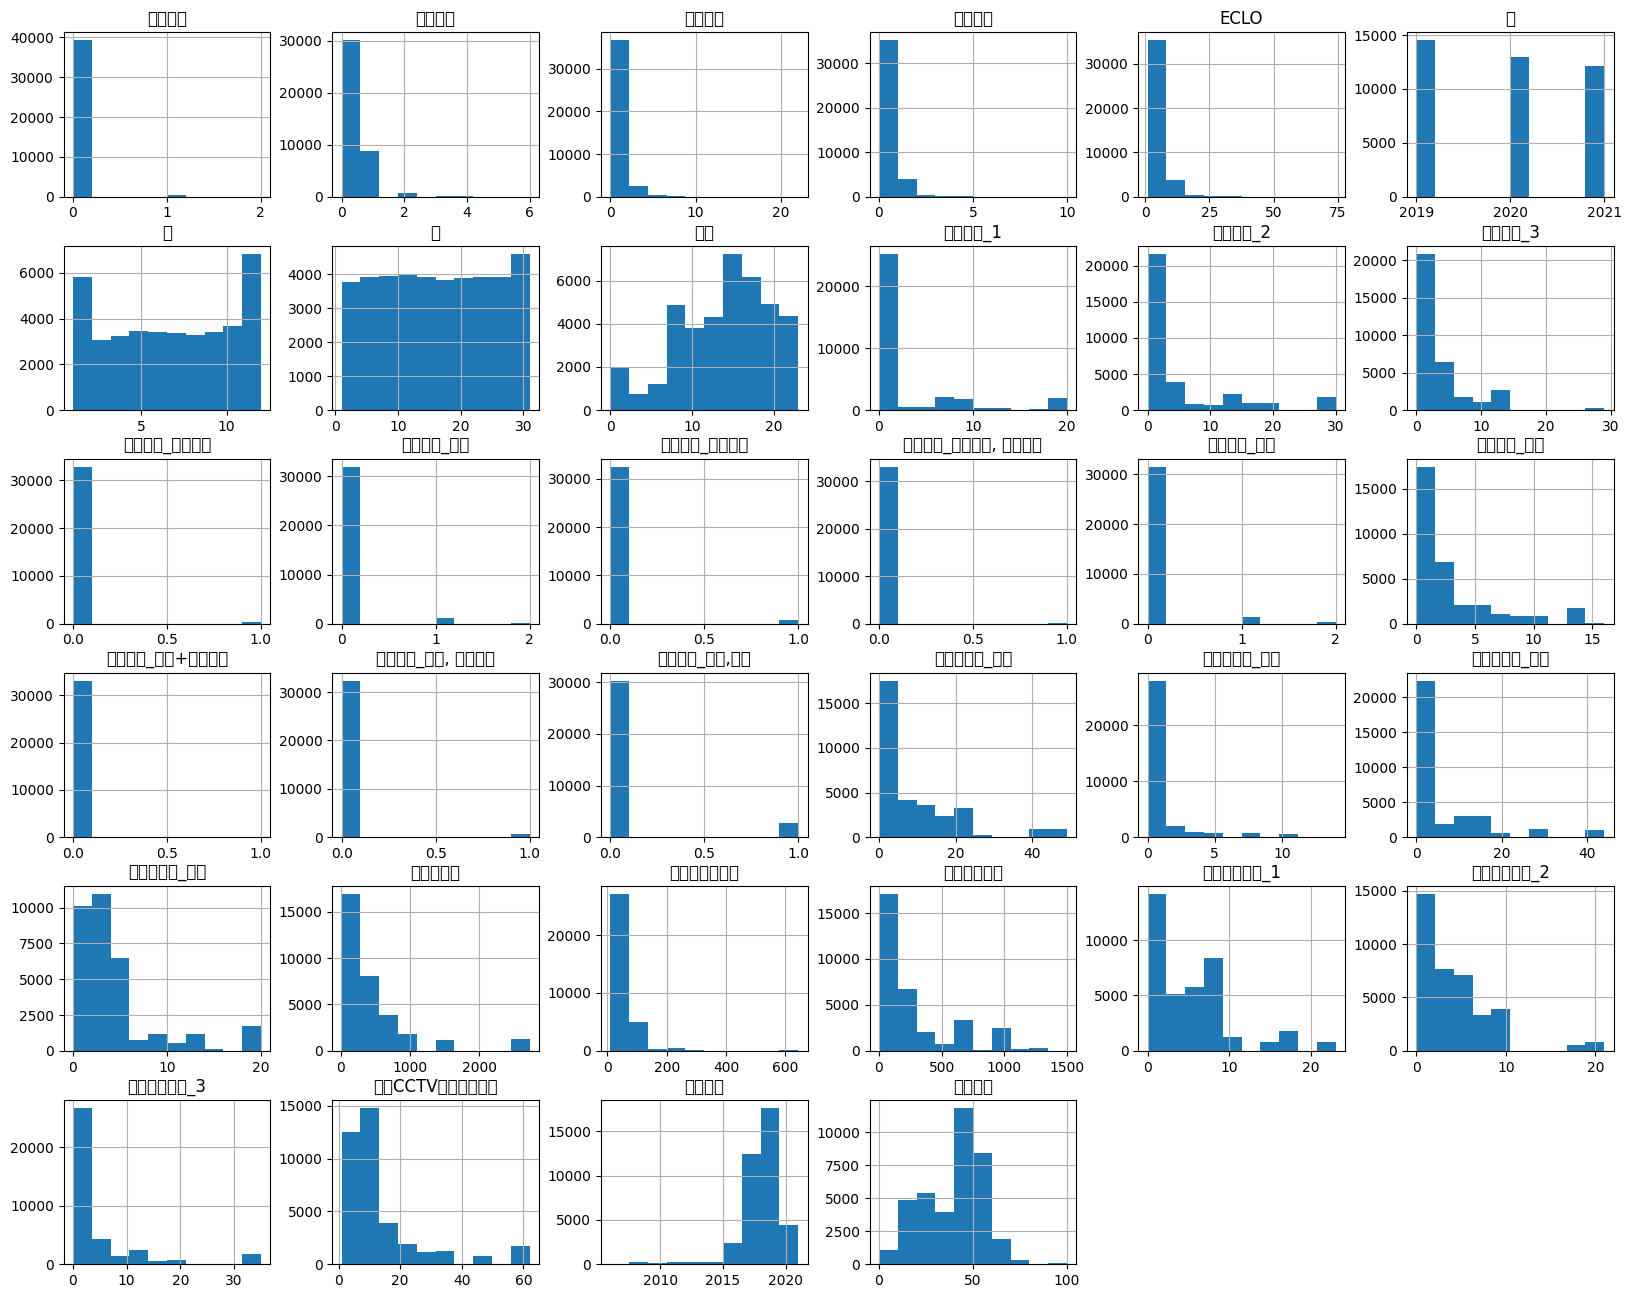

In [148]:
train_df.hist(figsize=(20,16))
plt.show()

<Axes: >

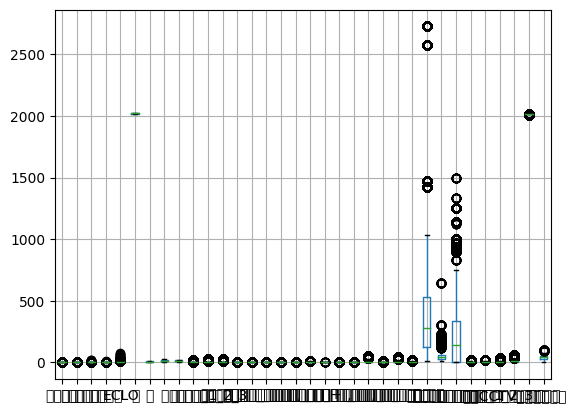

In [149]:
train_df.boxplot()

In [151]:
df_missing = train_df.copy()
np.sum(df_missing.isnull())
missing_number = df_missing.isnull().sum().sort_values(ascending=False)
missing_percentage = missing_number/len(df_missing)
missing_info = pd.concat([missing_number,missing_percentage],  axis=1, keys=['missing number','missing percentage'])
missing_info.head(30)

,missing number,missing percentage
급지구분_3,6543,0.165190
결제방법_무료,6543,0.165190
결제방법_신용카드,6543,0.165190
급지구분_2,6543,0.165190
급지구분_1,6543,0.165190
"결제방법_신용카드, 교통카드",6543,0.165190
결제방법_카드,6543,0.165190
결제방법_현금,6543,0.165190
결제방법_현금+신용카드,6543,0.165190
"결제방법_현금, 신용카드",6543,0.165190


## 2. 상관관계 파악

<Axes: >

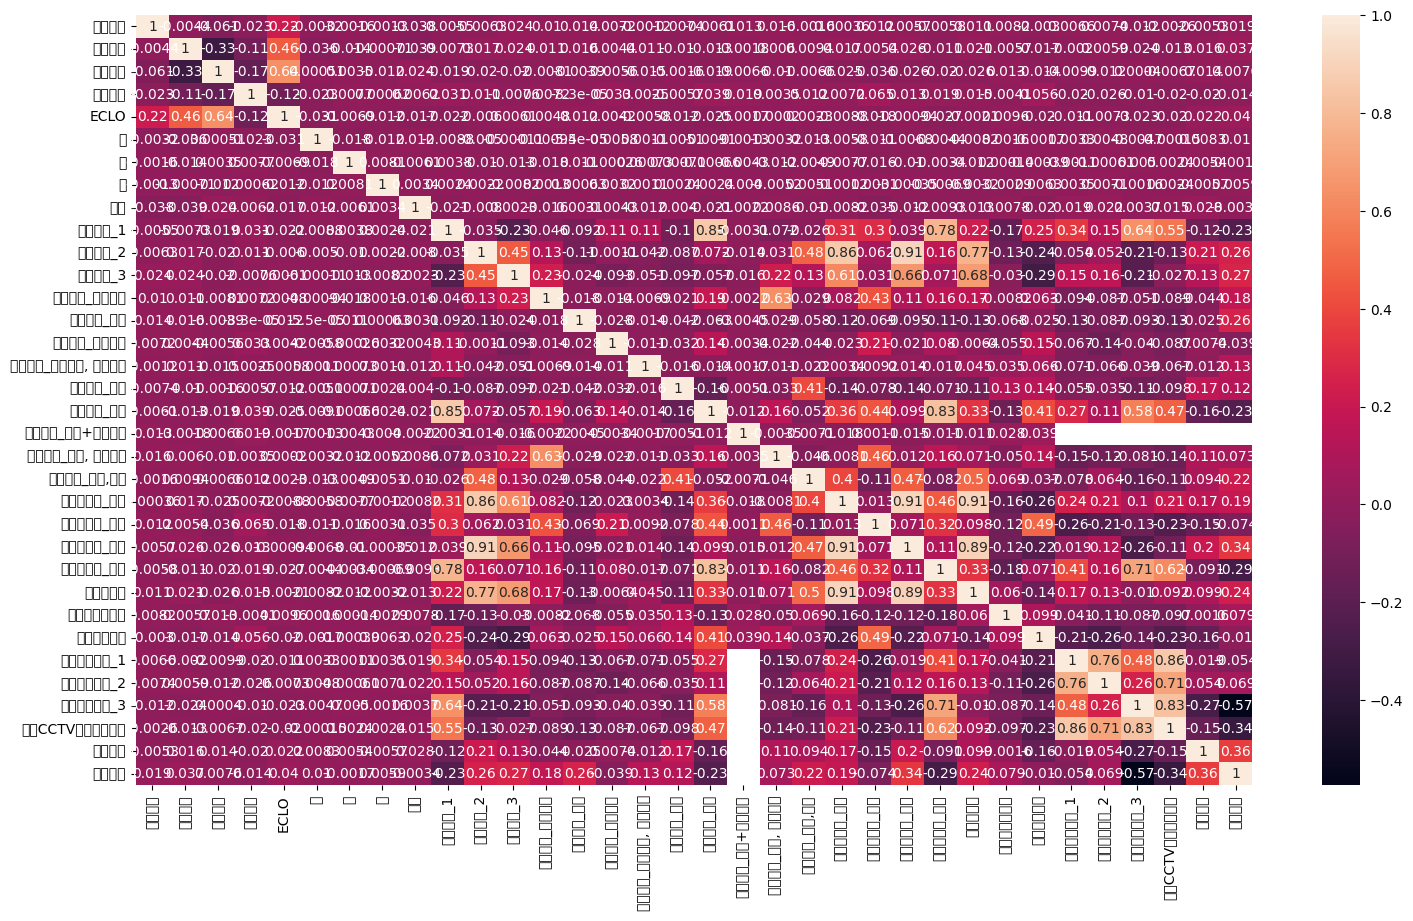

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(18,10))
sns.heatmap(train_df.corr(), annot=True)

In [153]:
df_train_corr = train_df.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

In [154]:
df_train_corr_nd.head(10)

,Feature 1,Feature 2,Correlation Coefficient
0,연,결제방법_무료,0.000055
2,부상자수,결제방법_무료,0.000083
4,연,급지구분_3,0.000108
6,월,주차구획수평균,0.000139
8,무인CCTV설치한곳의수,연,0.000151
10,ECLO,"결제방법_현금, 신용카드",0.000198
12,결제방법_신용카드,월,0.000265
14,주차장유형_노상,일,0.000354
16,사망자수,주차장구분_공영,0.000362
18,월,주차기본요금,0.000395


In [155]:
corr_na =  df_train_corr_nd[~df_train_corr_nd['Correlation Coefficient'].isna()]

In [156]:
corr_na.head(10)

,Feature 1,Feature 2,Correlation Coefficient
0,연,결제방법_무료,0.000055
2,부상자수,결제방법_무료,0.000083
4,연,급지구분_3,0.000108
6,월,주차구획수평균,0.000139
8,무인CCTV설치한곳의수,연,0.000151
10,ECLO,"결제방법_현금, 신용카드",0.000198
12,결제방법_신용카드,월,0.000265
14,주차장유형_노상,일,0.000354
16,사망자수,주차장구분_공영,0.000362
18,월,주차기본요금,0.000395


In [157]:
corr_na[np.logical_and(corr_na['Feature 1'] != 'ECLO', corr_na['Feature 2'] != 'ECLO')].tail(20)

,Feature 1,Feature 2,Correlation Coefficient
1068,주차장구분_공영,급지구분_3,0.609618
1070,무인CCTV설치한곳의수,주차장유형_노외,0.616398
1072,결제방법_교통카드,"결제방법_현금, 신용카드",0.632235
1076,급지구분_1,도로노선방향_3,0.642763
1078,주차장유형_노상,급지구분_3,0.663829
1080,주차구획수,급지구분_3,0.681488
1082,주차장유형_노외,도로노선방향_3,0.711533
1084,도로노선방향_2,무인CCTV설치한곳의수,0.712840
1086,도로노선방향_2,도로노선방향_1,0.757052
1088,주차구획수,급지구분_2,0.771437


In [158]:
df = train_df.copy()

In [159]:
df.fillna(0, inplace=True)

In [160]:
categorical_features = list(df.dtypes[df.dtypes == "object"].index)

for col in categorical_features:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

for i in range(corr_na.shape[0]):
  if corr_na['Correlation Coefficient'].iloc[i] > 0.9:
    pca_temp = pca.fit_transform(df[[corr_na['Feature 1'].iloc[i], corr_na['Feature 2'].iloc[i]]])
    df[corr_na['Feature 1'].iloc[i] + '_' + corr_na['Feature 2'].iloc[i]] = pca_temp

drop_lst = []

for i in range(corr_na.shape[0]):
  if corr_na['Correlation Coefficient'].iloc[i] > 0.9:
    drop_lst.append(corr_na['Feature 1'].iloc[i])
    drop_lst.append(corr_na['Feature 2'].iloc[i])

df.drop(drop_lst, axis=1, inplace=True)

In [162]:
df.shape

(39609, 44)

In [163]:
df_corr = df.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr.drop(df_corr.iloc[1::2].index, inplace=True)
df_corr_nd = df_corr.drop(df_corr[df_corr['Correlation Coefficient'] == 1.0].index)

In [164]:
corr_na =  df_corr_nd[~df_corr_nd['Correlation Coefficient'].isna()]

In [165]:
corr_na[np.logical_and(corr_na['Feature 1'] != 'ECLO', corr_na['Feature 2'] != 'ECLO')].tail(20)

,Feature 1,Feature 2,Correlation Coefficient
1764,"결제방법_현금, 신용카드",결제방법_교통카드,0.632949
1768,주차장유형_노외,무인CCTV설치한곳의수,0.645846
1770,도로노선방향_3,급지구분_1,0.653004
1772,주차장유형_노상_주차장구분_공영,급지구분_3,0.675810
1774,주차구획수_주차장구분_공영,급지구분_3,0.708846
1776,도로노선방향_3,주차장유형_노외,0.720638
1778,도로노선방향_2,무인CCTV설치한곳의수,0.724625
1780,도로노선방향_2,도로노선방향_1,0.768161
1782,주차장유형_노외,급지구분_1,0.782201
1784,도로노선방향_3,무인CCTV설치한곳의수,0.829611


In [166]:
for i in train_df.columns.tolist():
  num_by_region = train_df.groupby([i])['ECLO'].mean().sort_values(ascending=False)
  print(f'{i} : {num_by_region}')

ID : ID
ACCIDENT_32591    74.0
ACCIDENT_37536    66.0
ACCIDENT_10155    65.0
ACCIDENT_12632    57.0
ACCIDENT_10834    56.0
                  ... 
ACCIDENT_31604     1.0
ACCIDENT_31611     1.0
ACCIDENT_13102     1.0
ACCIDENT_37132     1.0
ACCIDENT_27455     1.0
Name: ECLO, Length: 39609, dtype: float64
요일 : 요일
일요일    5.210258
토요일    4.920811
월요일    4.698049
화요일    4.627926
수요일    4.627408
금요일    4.600906
목요일    4.560688
Name: ECLO, dtype: float64
기상상태 : 기상상태
안개    5.500000
기타    4.946429
비     4.895699
흐림    4.779150
맑음    4.712888
눈     4.625000
Name: ECLO, dtype: float64
도로형태 : 도로형태
단일로 - 터널           6.578125
단일로 - 고가도로위        5.615942
단일로 - 교량           5.211207
교차로 - 교차로안         5.006142
교차로 - 교차로부근        4.863035
단일로 - 기타           4.653990
단일로 - 지하차도(도로)내    4.576052
교차로 - 교차로횡단보도내     4.122795
기타 - 기타            4.065962
미분류 - 미분류          3.750000
주차장 - 주차장          3.716102
Name: ECLO, dtype: float64
노면상태 : 노면상태
침수       5.666667
젖음/습기    4.906452
건조       4.712878
서리/결빙   

In [170]:
for i in train_df.columns.tolist():
  Max= train_df.groupby([i])['ECLO'].mean().max()
  print(f'{i} : {Max}')
  Min= train_df.groupby([i])['ECLO'].mean().min()
  print(f'{i} : {Min}')
  print('---------------------------------')

ID : 74.0
ID : 1.0
---------------------------------
요일 : 5.210257656781721
요일 : 4.560687619378364
---------------------------------
기상상태 : 5.5
기상상태 : 4.625
---------------------------------
도로형태 : 6.578125
도로형태 : 3.7161016949152543
---------------------------------
노면상태 : 5.666666666666667
노면상태 : 3.0
---------------------------------
사고유형 : 4.944596507786692
사고유형 : 3.8176496414459242
---------------------------------
사망자수 : 27.875
사망자수 : 4.667786003205372
---------------------------------
중상자수 : 36.0
중상자수 : 4.089427926732148
---------------------------------
경상자수 : 74.0
경상자수 : 3.441878257543155
---------------------------------
부상자수 : 19.333333333333332
부상자수 : 2.8912506178942166
---------------------------------
ECLO : 74.0
ECLO : 1.0
---------------------------------
연 : 4.842184920198129
연 : 4.597049369488173
---------------------------------
월 : 4.88040629095675
월 : 4.5444512568976085
---------------------------------
일 : 4.889570552147239
일 : 4.527588813303099
--------------------

In [46]:
train_df.fillna(0, inplace=True)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['설치연도', '제한속도']])
train_df['설치연도' + '_' + '제한속도'] = pca_temp

pca_temp = pca.fit_transform(train_df[['주차구획수', '주차구획수평균']])
train_df['주차구획수' + '_' + '주차구획수평균'] = pca_temp

In [176]:
for i in train_df.columns.tolist():
  Max= train_df.groupby([i])['ECLO'].mean().max()
  print(f'{i} : {Max}')
  Min= train_df.groupby([i])['ECLO'].mean().min()
  print(f'{i} : {Min}')
  print('---------------------------------')

ID : 74.0
ID : 1.0
---------------------------------
요일 : 5.210257656781721
요일 : 4.560687619378364
---------------------------------
기상상태 : 5.5
기상상태 : 4.625
---------------------------------
도로형태 : 6.578125
도로형태 : 3.7161016949152543
---------------------------------
노면상태 : 5.666666666666667
노면상태 : 3.0
---------------------------------
사고유형 : 4.944596507786692
사고유형 : 3.8176496414459242
---------------------------------
사망자수 : 27.875
사망자수 : 4.667786003205372
---------------------------------
중상자수 : 36.0
중상자수 : 4.089427926732148
---------------------------------
경상자수 : 74.0
경상자수 : 3.441878257543155
---------------------------------
부상자수 : 19.333333333333332
부상자수 : 2.8912506178942166
---------------------------------
ECLO : 74.0
ECLO : 1.0
---------------------------------
연 : 4.842184920198129
연 : 4.597049369488173
---------------------------------
월 : 4.88040629095675
월 : 4.5444512568976085
---------------------------------
일 : 4.889570552147239
일 : 4.527588813303099
--------------------

In [48]:
categorical_features = list(train_df.dtypes[train_df.dtypes == "object"].index)

for col in categorical_features:
  le = LabelEncoder()
  train_df[col] = le.fit_transform(train_df[col])

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['설치연도_제한속도', '주차구획수_주차구획수평균']])
train_df['설치연도_제한속도' + '_' + '주차구획수_주차구획수평균'] = pca_temp

pca_temp = pca.fit_transform(train_df[['도로형태', '노면상태']])
train_df['도로형태' + '_' + '노면상태'] = pca_temp

In [181]:
for i in train_df.columns.tolist():
  Max= train_df.groupby([i])['ECLO'].mean().max()
  print(f'{i} : {Max}')
  Min= train_df.groupby([i])['ECLO'].mean().min()
  print(f'{i} : {Min}')
  print('---------------------------------')

ID : 74.0
ID : 1.0
---------------------------------
요일 : 5.210257656781721
요일 : 4.560687619378364
---------------------------------
기상상태 : 5.5
기상상태 : 4.625
---------------------------------
도로형태 : 6.578125
도로형태 : 3.7161016949152543
---------------------------------
노면상태 : 5.666666666666667
노면상태 : 3.0
---------------------------------
사고유형 : 4.944596507786692
사고유형 : 3.8176496414459242
---------------------------------
사망자수 : 27.875
사망자수 : 4.667786003205372
---------------------------------
중상자수 : 36.0
중상자수 : 4.089427926732148
---------------------------------
경상자수 : 74.0
경상자수 : 3.441878257543155
---------------------------------
부상자수 : 19.333333333333332
부상자수 : 2.8912506178942166
---------------------------------
ECLO : 74.0
ECLO : 1.0
---------------------------------
연 : 4.842184920198129
연 : 4.597049369488173
---------------------------------
월 : 4.88040629095675
월 : 4.5444512568976085
---------------------------------
일 : 4.889570552147239
일 : 4.527588813303099
--------------------

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['설치연도_제한속도_주차구획수_주차구획수평균', '도로형태_노면상태']])
train_df['설치연도_제한속도_주차구획수_주차구획수평균' + '_' + '도로형태_노면상태'] = pca_temp

pca_temp = pca.fit_transform(train_df[['도로형태', '노면상태']])
train_df['동' + '_' + '월'] = pca_temp

In [183]:
for i in train_df.columns.tolist():
  Max= train_df.groupby([i])['ECLO'].mean().max()
  print(f'{i} : {Max}')
  Min= train_df.groupby([i])['ECLO'].mean().min()
  print(f'{i} : {Min}')
  print('---------------------------------')

ID : 74.0
ID : 1.0
---------------------------------
요일 : 5.210257656781721
요일 : 4.560687619378364
---------------------------------
기상상태 : 5.5
기상상태 : 4.625
---------------------------------
도로형태 : 6.578125
도로형태 : 3.7161016949152543
---------------------------------
노면상태 : 5.666666666666667
노면상태 : 3.0
---------------------------------
사고유형 : 4.944596507786692
사고유형 : 3.8176496414459242
---------------------------------
사망자수 : 27.875
사망자수 : 4.667786003205372
---------------------------------
중상자수 : 36.0
중상자수 : 4.089427926732148
---------------------------------
경상자수 : 74.0
경상자수 : 3.441878257543155
---------------------------------
부상자수 : 19.333333333333332
부상자수 : 2.8912506178942166
---------------------------------
ECLO : 74.0
ECLO : 1.0
---------------------------------
연 : 4.842184920198129
연 : 4.597049369488173
---------------------------------
월 : 4.88040629095675
월 : 4.5444512568976085
---------------------------------
일 : 4.889570552147239
일 : 4.527588813303099
--------------------

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['설치연도_제한속도_주차구획수_주차구획수평균_도로형태_노면상태'
  , '동_월']])
train_df['설치연도_제한속도_주차구획수_주차구획수평균_도로형태_노면상태' + '_' + '동_월'] = pca_temp

pca_temp = pca.fit_transform(train_df[['요일', '시간']])
train_df['요일' + '_' + '시간'] = pca_temp

In [185]:
for i in train_df.columns.tolist():
  Max= train_df.groupby([i])['ECLO'].mean().max()
  print(f'{i} : {Max}')
  Min= train_df.groupby([i])['ECLO'].mean().min()
  print(f'{i} : {Min}')
  print('---------------------------------')

ID : 74.0
ID : 1.0
---------------------------------
요일 : 5.210257656781721
요일 : 4.560687619378364
---------------------------------
기상상태 : 5.5
기상상태 : 4.625
---------------------------------
도로형태 : 6.578125
도로형태 : 3.7161016949152543
---------------------------------
노면상태 : 5.666666666666667
노면상태 : 3.0
---------------------------------
사고유형 : 4.944596507786692
사고유형 : 3.8176496414459242
---------------------------------
사망자수 : 27.875
사망자수 : 4.667786003205372
---------------------------------
중상자수 : 36.0
중상자수 : 4.089427926732148
---------------------------------
경상자수 : 74.0
경상자수 : 3.441878257543155
---------------------------------
부상자수 : 19.333333333333332
부상자수 : 2.8912506178942166
---------------------------------
ECLO : 74.0
ECLO : 1.0
---------------------------------
연 : 4.842184920198129
연 : 4.597049369488173
---------------------------------
월 : 4.88040629095675
월 : 4.5444512568976085
---------------------------------
일 : 4.889570552147239
일 : 4.527588813303099
--------------------

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['설치연도_제한속도_주차구획수_주차구획수평균_도로형태_노면상태_동_월'
  , '요일_시간']])
train_df['설치연도_제한속도_주차구획수_주차구획수평균_도로형태_노면상태_동_월' + '_' + '요일_시간'] = pca_temp

In [187]:
for i in train_df.columns.tolist():
  Max= train_df.groupby([i])['ECLO'].mean().max()
  print(f'{i} : {Max}')
  Min= train_df.groupby([i])['ECLO'].mean().min()
  print(f'{i} : {Min}')
  print('---------------------------------')

ID : 74.0
ID : 1.0
---------------------------------
요일 : 5.210257656781721
요일 : 4.560687619378364
---------------------------------
기상상태 : 5.5
기상상태 : 4.625
---------------------------------
도로형태 : 6.578125
도로형태 : 3.7161016949152543
---------------------------------
노면상태 : 5.666666666666667
노면상태 : 3.0
---------------------------------
사고유형 : 4.944596507786692
사고유형 : 3.8176496414459242
---------------------------------
사망자수 : 27.875
사망자수 : 4.667786003205372
---------------------------------
중상자수 : 36.0
중상자수 : 4.089427926732148
---------------------------------
경상자수 : 74.0
경상자수 : 3.441878257543155
---------------------------------
부상자수 : 19.333333333333332
부상자수 : 2.8912506178942166
---------------------------------
ECLO : 74.0
ECLO : 1.0
---------------------------------
연 : 4.842184920198129
연 : 4.597049369488173
---------------------------------
월 : 4.88040629095675
월 : 4.5444512568976085
---------------------------------
일 : 4.889570552147239
일 : 4.527588813303099
--------------------